In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))  
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid):    
    figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    #figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = len(GRAPH)
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        print(graph_name)
        print(lcc_mix)
        print(lcc_ba)
        
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''


        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')

    figure.text(0.5, 0.03,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.04, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure/HDA/"+title)
    plt.show()

# Synthetic Network:- Heterogeneity and Homogeneity

In [22]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 348500
MIX = 5000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


heterogeneous_30
[23, 20, 19, 16, 15, 11, 6, 3]
[23, 21, 20, 19, 9, 6, 6, 3]
heterogeneous_50
[36, 35, 34, 31, 30, 17, 12, 11, 9, 6, 4]
[36, 35, 32, 31, 30, 28, 23, 16, 8, 6, 6, 4]
heterogeneous_100
[76, 74, 71, 68, 67, 64, 62, 60, 58, 47, 28, 13, 13, 13, 9]
[76, 74, 71, 70, 65, 62, 59, 58, 55, 53, 38, 30, 13, 13, 13, 13, 9]
heterogeneous_500
[414, 412, 411, 408, 404, 401, 399, 397, 395, 392, 391, 389, 387, 383, 378, 376, 375, 371, 369, 368, 366, 361, 357, 354, 292, 291, 286, 283, 280, 280, 279, 276, 276, 273, 268, 266, 261, 248, 247, 244, 242, 210, 209, 201, 199, 199, 181, 178, 161, 80, 80, 80, 80, 78, 78, 65, 65, 65, 65, 58]
[414, 413, 411, 409, 408, 405, 403, 401, 398, 395, 394, 390, 388, 387, 385, 383, 376, 371, 369, 366, 365, 361, 360, 296, 293, 289, 286, 283, 278, 277, 274, 274, 274, 271, 270, 268, 251, 250, 248, 248, 247, 242, 230, 225, 225, 136, 136, 119, 119, 117, 100, 84, 71, 61]


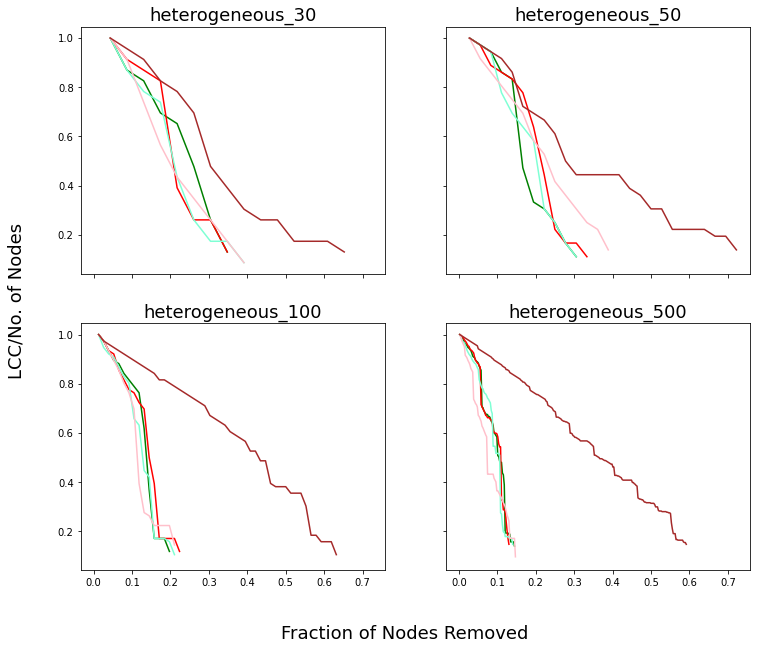

In [23]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"heterogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])


In [24]:
BA = 59000 
MIX =461500
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


homogeneous_30
[29, 27, 26, 25, 19, 17, 16, 14, 9, 9, 6, 6, 3]
[29, 27, 26, 25, 23, 21, 20, 14, 9, 9, 6, 4]
homogeneous_50
[50, 49, 48, 47, 46, 45, 42, 39, 22, 22, 12, 9, 9, 8, 8, 8, 5]
[50, 49, 48, 47, 46, 45, 42, 39, 33, 22, 17, 17, 9, 8, 8, 7]
homogeneous_100
[94, 92, 91, 90, 89, 88, 87, 86, 84, 72, 72, 37, 37, 37, 37, 37, 30, 30, 29, 23, 22, 13]
[94, 92, 91, 90, 86, 85, 84, 83, 81, 80, 79, 77, 74, 71, 68, 45, 45, 45, 42, 22, 19, 13]
homogeneous_500
[466, 465, 464, 463, 461, 460, 459, 457, 455, 453, 451, 450, 449, 444, 443, 442, 441, 440, 439, 437, 434, 431, 282, 282, 282, 282, 282, 278, 150, 150, 149, 148, 145, 144, 141, 140, 134, 132, 131, 131, 131, 131, 131, 130, 127, 127, 125, 125, 95, 95, 93, 90, 90, 90, 89, 89, 87, 86, 83, 83, 83, 83, 83, 83, 83, 83, 83, 76, 76, 76, 76, 56]
[466, 464, 463, 462, 460, 458, 457, 456, 454, 452, 451, 449, 448, 446, 441, 440, 439, 438, 437, 436, 433, 429, 426, 425, 423, 420, 419, 416, 414, 410, 409, 406, 404, 401, 399, 258, 140, 140, 140, 140, 138, 

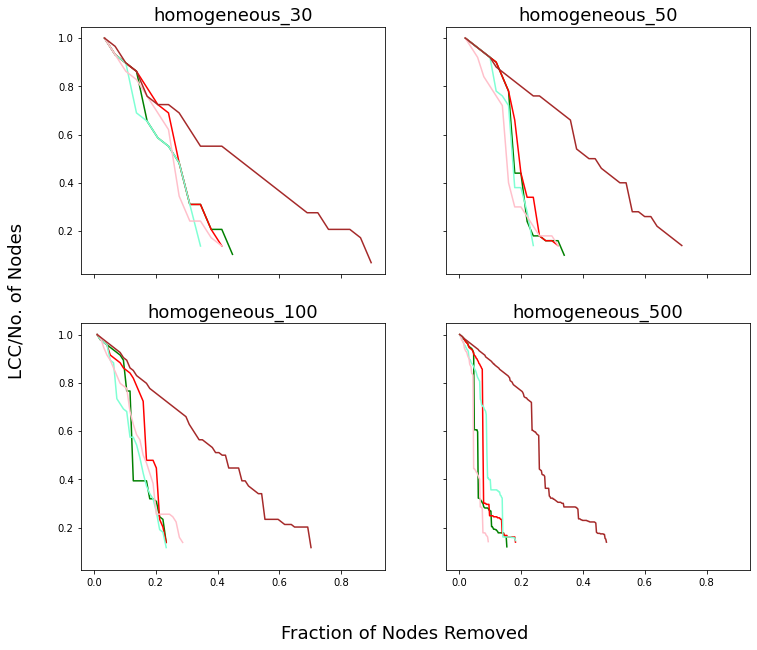

In [25]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"homogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])

# Synthetic with Motifs Attached

In [14]:
BA = 474500 
MIX = 429000
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


ba_300_20_house_1
[400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 368, 367, 366, 364, 353, 352, 351, 350, 348, 347, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 329, 328, 327, 325, 324, 323, 322, 320, 319, 318, 314, 313, 312, 311, 309, 308, 307, 306, 305, 304, 300, 285, 283, 277, 271, 270, 267, 261, 255, 254, 253, 251, 248, 246, 244, 241, 235, 230, 227, 219, 217, 216, 214, 213, 212, 198, 194, 193, 192, 191, 190, 185, 181, 177, 171, 168, 166, 158, 153, 145, 115, 100, 99, 81, 81, 81, 81, 80, 75, 75, 74, 73, 69, 69, 68, 64, 64, 64, 64, 35]
[400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 368, 367, 366, 365, 363, 362, 361, 359, 358, 357, 355, 354, 353, 352, 351, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 327, 326, 324, 323, 322, 321, 320, 318, 317, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 304, 303, 297, 291, 290

ba_300_60_fan_3
[360, 358, 357, 356, 355, 354, 353, 352, 351, 349, 348, 347, 346, 345, 344, 343, 342, 340, 339, 338, 337, 336, 335, 334, 333, 331, 329, 328, 326, 325, 324, 322, 320, 318, 317, 316, 315, 313, 311, 309, 306, 305, 303, 301, 300, 298, 296, 295, 294, 293, 292, 288, 287, 286, 285, 284, 282, 280, 278, 276, 275, 274, 270, 269, 268, 266, 264, 261, 260, 259, 257, 255, 254, 251, 250, 248, 247, 246, 245, 244, 242, 240, 236, 229, 223, 221, 220, 218, 216, 215, 214, 213, 212, 211, 210, 209, 208, 207, 203, 201, 199, 195, 193, 189, 185, 176, 172, 169, 168, 163, 157, 154, 151, 149, 147, 146, 145, 144, 141, 140, 139, 138, 131, 130, 121, 120, 104, 104, 41]
[360, 358, 357, 356, 355, 354, 353, 352, 351, 350, 348, 347, 346, 345, 344, 343, 342, 341, 340, 338, 337, 336, 335, 334, 333, 332, 330, 329, 327, 325, 324, 322, 320, 319, 318, 317, 316, 314, 312, 309, 307, 305, 303, 301, 300, 299, 298, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 283, 281, 280, 279, 277, 275, 273, 272, 271, 269, 265

ba_300_100_clique_5
[301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 253, 252, 251, 250, 249, 248, 247, 246, 244, 242, 240, 238, 237, 236, 235, 233, 231, 230, 228, 227, 226, 225, 224, 222, 220, 217, 216, 215, 214, 212, 211, 210, 209, 208, 205, 204, 203, 202, 200, 197, 196, 195, 193, 191, 188, 184, 181, 180, 179, 178, 177, 174, 173, 170, 167, 166, 157, 155, 153, 148, 146, 143, 129, 124, 123, 122, 114, 113, 110, 106, 53, 52, 51, 51, 51, 51, 50, 49, 49, 47, 45]
[301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 242, 240, 238, 236, 235, 234, 233, 231, 229, 228, 227, 226, 225, 224,

ba_300_100_diamond_5
[900, 899, 898, 891, 890, 889, 888, 887, 886, 885, 884, 877, 876, 875, 874, 867, 866, 865, 864, 863, 862, 861, 854, 853, 852, 851, 844, 843, 842, 841, 839, 838, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 813, 812, 805, 804, 803, 802, 801, 800, 799, 798, 797, 796, 794, 787, 786, 785, 784, 783, 782, 781, 780, 779, 778, 777, 770, 769, 768, 761, 760, 759, 758, 751, 750, 749, 748, 741, 740, 733, 732, 731, 723, 722, 715, 708, 707, 706, 704, 703, 702, 687, 686, 685, 684, 677, 676, 663, 662, 656, 655, 654, 653, 652, 651, 650, 649, 642, 641, 640, 639, 628, 621, 604, 603, 594, 593, 592, 591, 590, 589, 588, 581, 580, 579, 566, 565, 555, 548, 547, 546, 540, 539, 538, 537, 532, 531, 520, 504, 489, 481, 474, 471, 463, 455, 454, 447, 446, 432, 431, 430, 424, 423, 422, 402, 401, 395, 380, 379, 378, 378, 376, 370, 364, 364, 358, 352, 346, 340, 334, 321, 314, 308, 302, 296, 290, 284, 278, 272, 266, 260, 254, 254, 254, 248, 242, 236, 230, 224, 218, 206, 200, 182, 176

ba_300_40_star_2
[340, 338, 337, 336, 335, 334, 333, 332, 330, 328, 327, 326, 325, 323, 322, 321, 320, 319, 317, 316, 314, 313, 312, 311, 310, 309, 307, 306, 305, 304, 303, 302, 301, 299, 298, 297, 295, 292, 291, 290, 289, 288, 287, 286, 284, 283, 282, 280, 279, 278, 277, 276, 274, 273, 270, 269, 268, 267, 265, 264, 262, 260, 258, 257, 256, 254, 253, 251, 249, 246, 245, 242, 241, 240, 238, 235, 232, 231, 228, 225, 222, 218, 216, 213, 210, 209, 207, 206, 204, 202, 201, 199, 194, 190, 188, 187, 185, 172, 146, 144, 143, 142, 140, 123, 122, 121, 120, 119, 97, 96, 82, 67, 57, 41]
[340, 338, 337, 336, 335, 334, 333, 332, 331, 329, 327, 326, 325, 323, 322, 321, 320, 319, 318, 316, 315, 313, 312, 311, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 298, 297, 296, 295, 294, 293, 292, 289, 288, 287, 286, 285, 284, 282, 281, 280, 278, 277, 275, 274, 273, 272, 270, 268, 267, 266, 265, 264, 262, 261, 259, 257, 256, 253, 252, 251, 249, 247, 246, 245, 243, 242, 240, 239, 236, 232, 225, 224, 222, 22

ba_300_80_grid_4
[1020, 1019, 1018, 1017, 1016, 1015, 1005, 1004, 1003, 1002, 1001, 1000, 999, 998, 997, 996, 995, 985, 984, 983, 982, 981, 980, 979, 978, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 955, 954, 953, 952, 942, 932, 931, 921, 920, 919, 917, 916, 915, 914, 913, 912, 902, 901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 881, 880, 870, 869, 868, 867, 857, 847, 827, 826, 814, 813, 812, 811, 810, 789, 779, 778, 777, 776, 755, 754, 753, 752, 751, 750, 749, 748, 747, 746, 745, 744, 743, 742, 741, 740, 739, 738, 737, 736, 735, 725, 724, 723, 722, 721, 720, 710, 708, 707, 688, 687, 686, 676, 675, 674, 673, 672, 671, 670, 666, 665, 664, 654, 645, 638, 632, 631, 630, 629, 628, 627, 607, 604, 601, 580, 579, 577, 576, 575, 544, 534, 533, 532, 531, 511, 510, 509, 506, 505, 486, 485, 485, 476, 466, 465, 464, 446, 446, 445, 443, 419, 418, 417, 387, 386, 252, 251, 250, 249, 237, 237, 237, 237, 237, 236, 215, 202, 198, 172, 156, 156, 156, 156, 156, 80]
[1020, 1019, 101

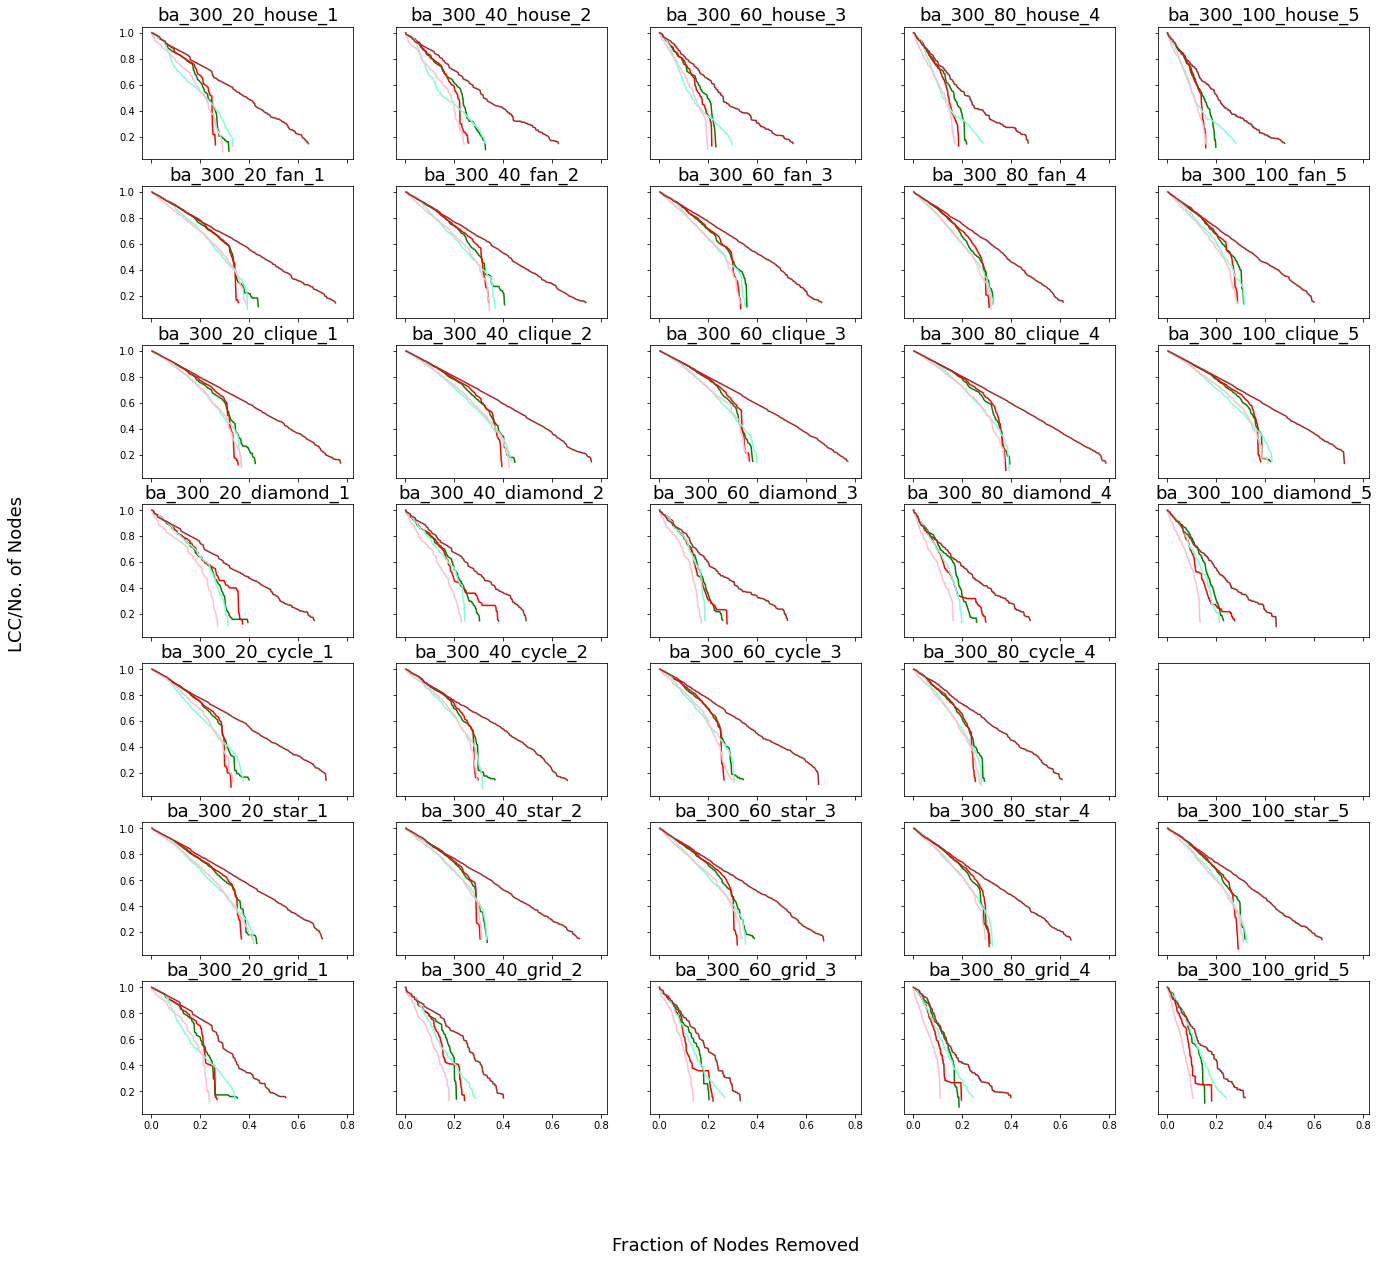

In [15]:
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


In [16]:
BA = 476000
MIX = 1000
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


tree_8_20_house_1
[611, 610, 605, 590, 589, 574, 573, 566, 565, 564, 559, 539, 535, 534, 533, 532, 524, 516, 515, 514, 512, 511, 506, 505, 501, 497, 496, 489, 489, 487, 486, 481, 480, 460, 453, 419, 404, 399, 394, 389, 384, 384, 384, 384, 373, 327, 326, 319, 313, 297, 296, 272, 269, 187, 117, 117, 117, 94, 94, 94, 94, 94, 94, 94, 53]
[611, 609, 604, 603, 597, 582, 581, 576, 575, 574, 554, 553, 545, 541, 540, 532, 513, 512, 511, 510, 499, 498, 473, 472, 465, 457, 450, 448, 438, 437, 435, 435, 409, 389, 384, 377, 375, 375, 370, 358, 353, 348, 348, 348, 343, 325, 324, 324, 324, 300, 179, 107, 107, 107, 107, 100, 99, 99, 99, 64]
tree_8_40_house_2
[711, 710, 709, 708, 705, 704, 700, 699, 694, 693, 692, 684, 677, 676, 675, 666, 665, 662, 655, 654, 650, 649, 644, 643, 618, 613, 608, 595, 594, 588, 587, 586, 568, 560, 559, 553, 545, 537, 529, 522, 522, 521, 509, 467, 466, 444, 400, 392, 391, 386, 385, 385, 369, 369, 369, 363, 363, 358, 353, 353, 348, 348, 343, 338, 333, 328, 323, 318, 313, 303

tree_8_60_clique_3
[512, 511, 510, 509, 506, 504, 501, 485, 484, 474, 459, 444, 442, 441, 433, 429, 426, 418, 407, 388, 380, 378, 362, 355, 346, 338, 330, 315, 311, 297, 258, 229, 214, 141, 113, 112, 103, 88, 88, 88, 88, 88, 88, 65]
[512, 511, 510, 509, 508, 506, 503, 487, 484, 468, 467, 452, 451, 443, 433, 432, 431, 429, 421, 405, 404, 397, 393, 364, 335, 335, 314, 307, 298, 269, 266, 258, 258, 243, 236, 234, 231, 224, 224, 146, 146, 105, 83, 79, 58]
tree_8_80_clique_4
[512, 511, 510, 509, 502, 501, 500, 499, 496, 495, 488, 486, 479, 478, 476, 468, 467, 456, 416, 410, 391, 390, 387, 386, 385, 381, 381, 354, 353, 351, 349, 338, 320, 319, 267, 267, 228, 213, 213, 188, 170, 86, 86, 86, 71]
[512, 511, 510, 509, 508, 507, 500, 499, 498, 496, 495, 492, 491, 483, 481, 480, 473, 463, 461, 450, 449, 446, 442, 440, 417, 414, 388, 374, 373, 370, 354, 347, 302, 302, 281, 281, 154, 154, 154, 138, 138, 119, 119, 93, 86, 86, 86, 86, 85, 73]
tree_8_100_clique_5
[512, 511, 507, 506, 503, 502, 501, 493

tree_8_20_cycle_1
[631, 616, 608, 592, 591, 588, 581, 537, 524, 516, 459, 278, 278, 278, 231, 187, 163, 163, 163, 106, 106, 101, 98, 98, 98, 86]
[631, 603, 602, 594, 593, 562, 558, 545, 543, 530, 441, 282, 282, 270, 270, 164, 138, 138, 138, 127, 127, 118, 118, 106, 91]
tree_8_40_cycle_2
[751, 738, 728, 727, 706, 657, 630, 596, 589, 573, 519, 480, 460, 447, 420, 339, 318, 304, 303, 259, 259, 259, 238, 238, 238, 217, 217, 196, 196, 79]
[751, 750, 749, 739, 738, 737, 728, 721, 694, 678, 629, 602, 581, 561, 557, 550, 537, 524, 511, 484, 476, 434, 431, 431, 350, 350, 240, 237, 237, 225, 216, 136, 136, 120, 120, 120, 120, 111]
tree_8_60_cycle_3
[871, 870, 862, 861, 860, 859, 832, 831, 798, 771, 770, 743, 735, 706, 542, 519, 428, 379, 352, 351, 351, 344, 314, 287, 287, 266, 266, 253, 250, 237, 237, 98]
[871, 869, 813, 805, 804, 755, 728, 695, 688, 639, 638, 611, 557, 493, 493, 477, 447, 424, 411, 411, 372, 353, 353, 350, 350, 347, 344, 344, 344, 335, 326, 317, 308, 296, 284, 284, 284, 244, 24

tree_8_60_grid_3
[2671, 2670, 2667, 2666, 2665, 2664, 2663, 2662, 2661, 2660, 2659, 2657, 2655, 2654, 2653, 2652, 2651, 2650, 2649, 2648, 2647, 2646, 2645, 2644, 2643, 2642, 2641, 2640, 2639, 2638, 2637, 2636, 2635, 2634, 2633, 2632, 2631, 2630, 2629, 2628, 2627, 2626, 2625, 2624, 2623, 2622, 2621, 2620, 2619, 2617, 2616, 2615, 2614, 2613, 2612, 2611, 2610, 2609, 2608, 2607, 2606, 2605, 2604, 2603, 2602, 2601, 2600, 2599, 2598, 2597, 2596, 2595, 2594, 2593, 2592, 2591, 2590, 2589, 2588, 2587, 2586, 2585, 2584, 2583, 2582, 2581, 2580, 2579, 2578, 2577, 2576, 2575, 2574, 2573, 2572, 2571, 2570, 2569, 2568, 2567, 2566, 2565, 2564, 2563, 2562, 2561, 2560, 2559, 2558, 2557, 2556, 2555, 2554, 2553, 2552, 2551, 2550, 2549, 2548, 2547, 2546, 2545, 2544, 2543, 2542, 2541, 2540, 2539, 2538, 2537, 2536, 2535, 2534, 2533, 2532, 2531, 2530, 2529, 2528, 2527, 2526, 2525, 2524, 2523, 2522, 2521, 2520, 2519, 2518, 2517, 2516, 2515, 2514, 2513, 2512, 2511, 2510, 2509, 2508, 2507, 2506, 2505, 2504, 2503

tree_8_100_grid_5
[4111, 4110, 4109, 4108, 4107, 4106, 4105, 4101, 4097, 4096, 4095, 4094, 4093, 4092, 4091, 4090, 4089, 4088, 4087, 4086, 4085, 4084, 4083, 4082, 4081, 4080, 4079, 4078, 4077, 4076, 4075, 4074, 4073, 4072, 4071, 4070, 4069, 4068, 4067, 4066, 4065, 4064, 4063, 4062, 4061, 4060, 4059, 4058, 4057, 4056, 4055, 4054, 4053, 4052, 4051, 4050, 4049, 4048, 4047, 4046, 4045, 4044, 4043, 4042, 4041, 4040, 4039, 4038, 4037, 4036, 4035, 4034, 4033, 4032, 4031, 4030, 4029, 4028, 4027, 4026, 4025, 4024, 4023, 4022, 4021, 4020, 4019, 4018, 4017, 4016, 4015, 4014, 4013, 4012, 4011, 4010, 4009, 4008, 4007, 4006, 4005, 4004, 4003, 4002, 4001, 4000, 3999, 3998, 3997, 3996, 3995, 3994, 3993, 3992, 3991, 3990, 3989, 3988, 3987, 3986, 3985, 3984, 3983, 3982, 3981, 3980, 3979, 3978, 3977, 3976, 3975, 3974, 3973, 3972, 3971, 3970, 3969, 3968, 3967, 3966, 3965, 3964, 3963, 3962, 3961, 3960, 3959, 3958, 3957, 3956, 3955, 3954, 3953, 3952, 3951, 3950, 3949, 3948, 3947, 3946, 3945, 3944, 3943, 394

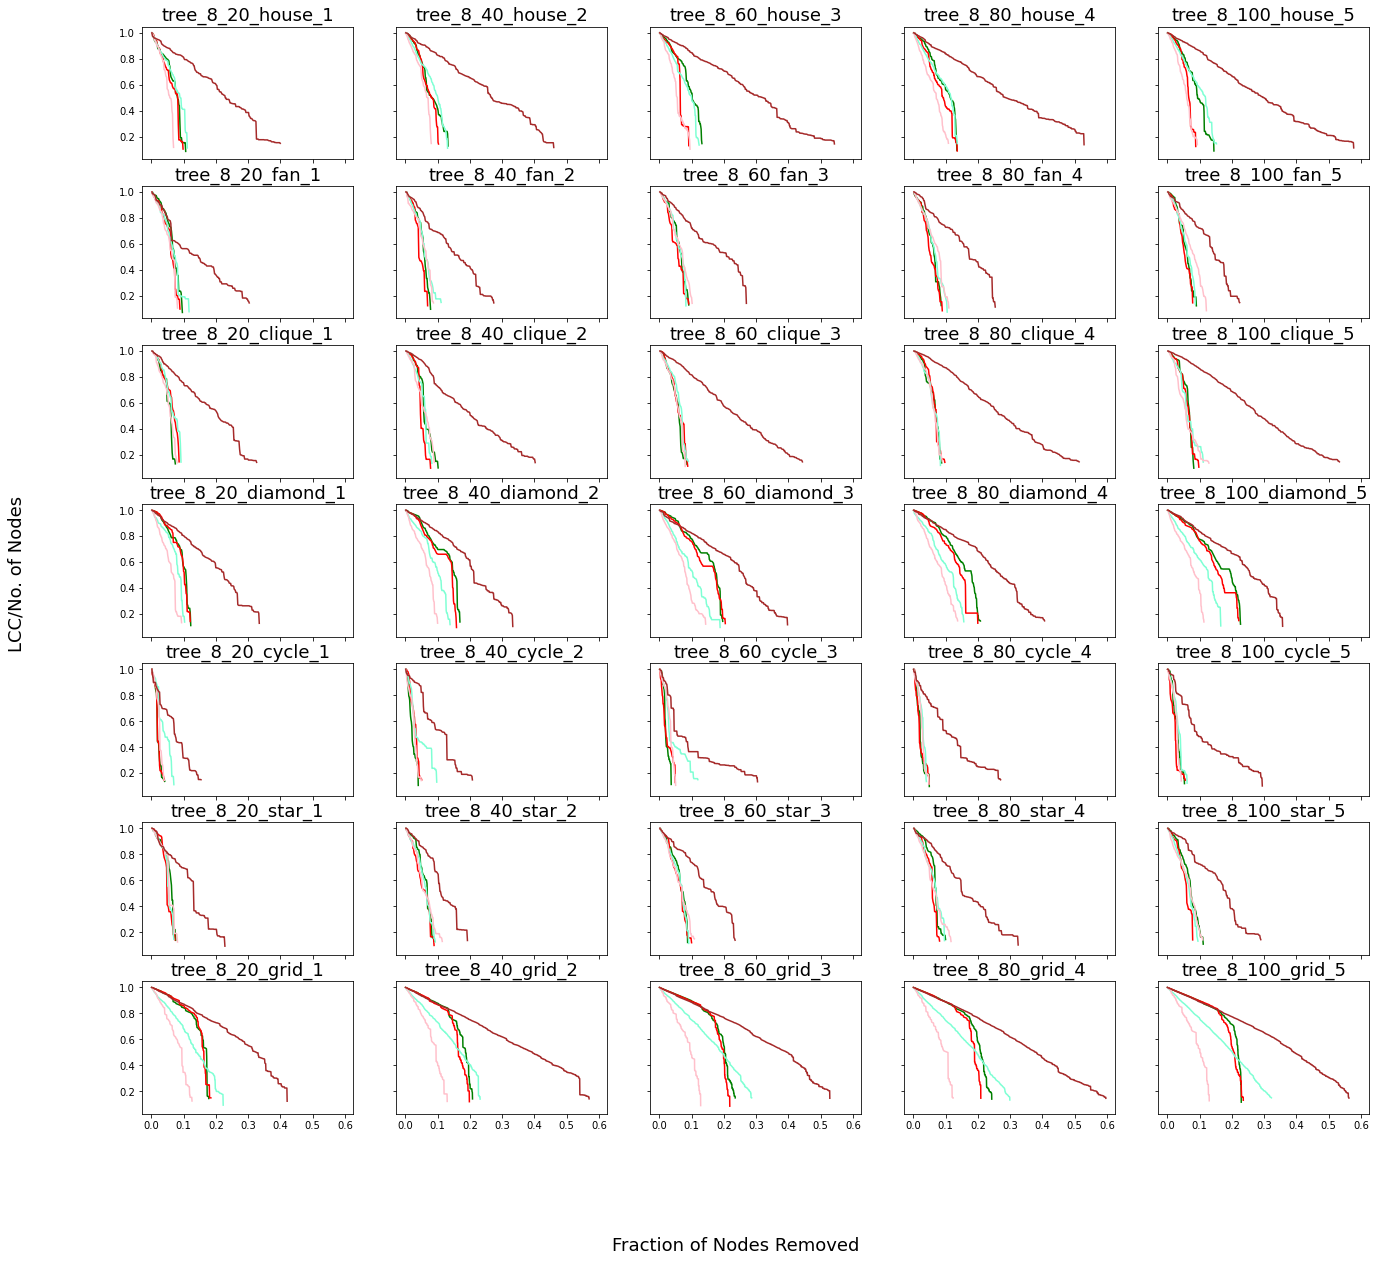

In [17]:
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


## Cancer Gene

COAD
[4120, 4093, 4092, 4088, 4061, 4049, 4028, 4010, 4005, 4004, 3997, 3991, 3990, 3978, 3974, 3952, 3951, 3950, 3949, 3934, 3928, 3906, 3902, 3877, 3876, 3875, 3867, 3866, 3865, 3864, 3824, 3814, 3811, 3807, 3806, 3805, 3800, 3799, 3798, 3797, 3796, 3795, 3794, 3793, 3792, 3791, 3789, 3788, 3786, 3768, 3767, 3759, 3758, 3757, 3756, 3755, 3754, 3753, 3752, 3748, 3747, 3743, 3739, 3738, 3737, 3736, 3735, 3720, 3719, 3718, 3701, 3700, 3698, 3697, 3696, 3695, 3692, 3691, 3690, 3688, 3686, 3680, 3679, 3678, 3677, 3674, 3669, 3668, 3667, 3666, 3664, 3663, 3662, 3661, 3660, 3659, 3657, 3656, 3655, 3654, 3653, 3652, 3651, 3642, 3641, 3640, 3639, 3638, 3637, 3636, 3635, 3634, 3633, 3632, 3631, 3630, 3627, 3624, 3623, 3622, 3621, 3620, 3619, 3618, 3617, 3616, 3615, 3614, 3605, 3604, 3603, 3601, 3600, 3585, 3584, 3578, 3576, 3575, 3574, 3573, 3572, 3571, 3570, 3569, 3568, 3567, 3566, 3558, 3557, 3556, 3555, 3554, 3553, 3550, 3549, 3548, 3542, 3541, 3540, 3519, 3518, 3510, 3509, 3508, 3507, 3506

HNSC
[5116, 5061, 5060, 5059, 5058, 5057, 5056, 5055, 5054, 5053, 5051, 5050, 5049, 5048, 5047, 5046, 5045, 4968, 4966, 4965, 4964, 4962, 4961, 4960, 4959, 4958, 4957, 4956, 4955, 4954, 4953, 4952, 4951, 4950, 4949, 4948, 4947, 4946, 4945, 4942, 4940, 4939, 4937, 4936, 4935, 4932, 4931, 4930, 4925, 4924, 4923, 4922, 4921, 4920, 4918, 4917, 4916, 4915, 4914, 4912, 4911, 4910, 4909, 4907, 4904, 4903, 4902, 4901, 4900, 4898, 4897, 4896, 4894, 4891, 4890, 4889, 4886, 4885, 4884, 4883, 4882, 4881, 4880, 4879, 4878, 4874, 4871, 4870, 4869, 4867, 4866, 4865, 4864, 4863, 4862, 4860, 4859, 4858, 4857, 4855, 4854, 4853, 4852, 4850, 4849, 4848, 4846, 4836, 4835, 4833, 4832, 4831, 4830, 4829, 4828, 4827, 4825, 4824, 4823, 4822, 4821, 4820, 4819, 4818, 4817, 4816, 4815, 4814, 4813, 4812, 4811, 4810, 4809, 4808, 4807, 4806, 4805, 4804, 4803, 4802, 4801, 4800, 4799, 4787, 4786, 4785, 4784, 4783, 4782, 4781, 4780, 4779, 4778, 4777, 4772, 4771, 4770, 4769, 4768, 4767, 4766, 4765, 4764, 4763, 4762, 4761

KICH
[2273, 2239, 2205, 2172, 2112, 2080, 2052, 2022, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1652, 1652, 1619, 1619, 1597, 1597, 1597, 1597, 1597, 1579, 1579, 1579, 1572, 1539, 1539, 1539, 1539, 1539, 1529, 1518, 1506, 1506, 1506, 1505, 1504, 1493, 1492, 1491, 1490, 1478, 1477, 1470, 1469, 1460, 1446, 1445, 1444, 1443, 1442, 1432, 1432, 1408, 1407, 1406, 1405, 1398, 1397, 1396, 1395, 1394, 1393, 1392, 1391, 1390, 1389, 1388, 1388, 1387, 1386, 1385, 1372, 1371, 1370, 1369, 1363, 1363, 1356, 1356, 1355, 1354, 1335, 1334, 1333, 1329, 1328, 1327, 1312, 1290, 1273, 1264, 1258, 1257, 1256, 1255, 1254, 1253, 1253, 1250, 1249, 1248, 1247, 1246, 1221, 1217, 1210, 1199, 1185, 1179, 1179, 1172, 1171, 1166, 1157, 1157, 1155, 1154, 1153, 1150, 1149, 1148, 1147, 1146, 1146, 1136, 1135, 1134, 1132, 1131, 1130, 1104, 1103, 1092, 1092, 1083, 1070, 1069, 1068, 1068, 1067, 1066, 1041, 1037, 1036, 1019, 1010, 977, 974, 948, 946, 946, 932, 931, 926, 923, 913, 904, 903, 902, 871, 863, 845, 83

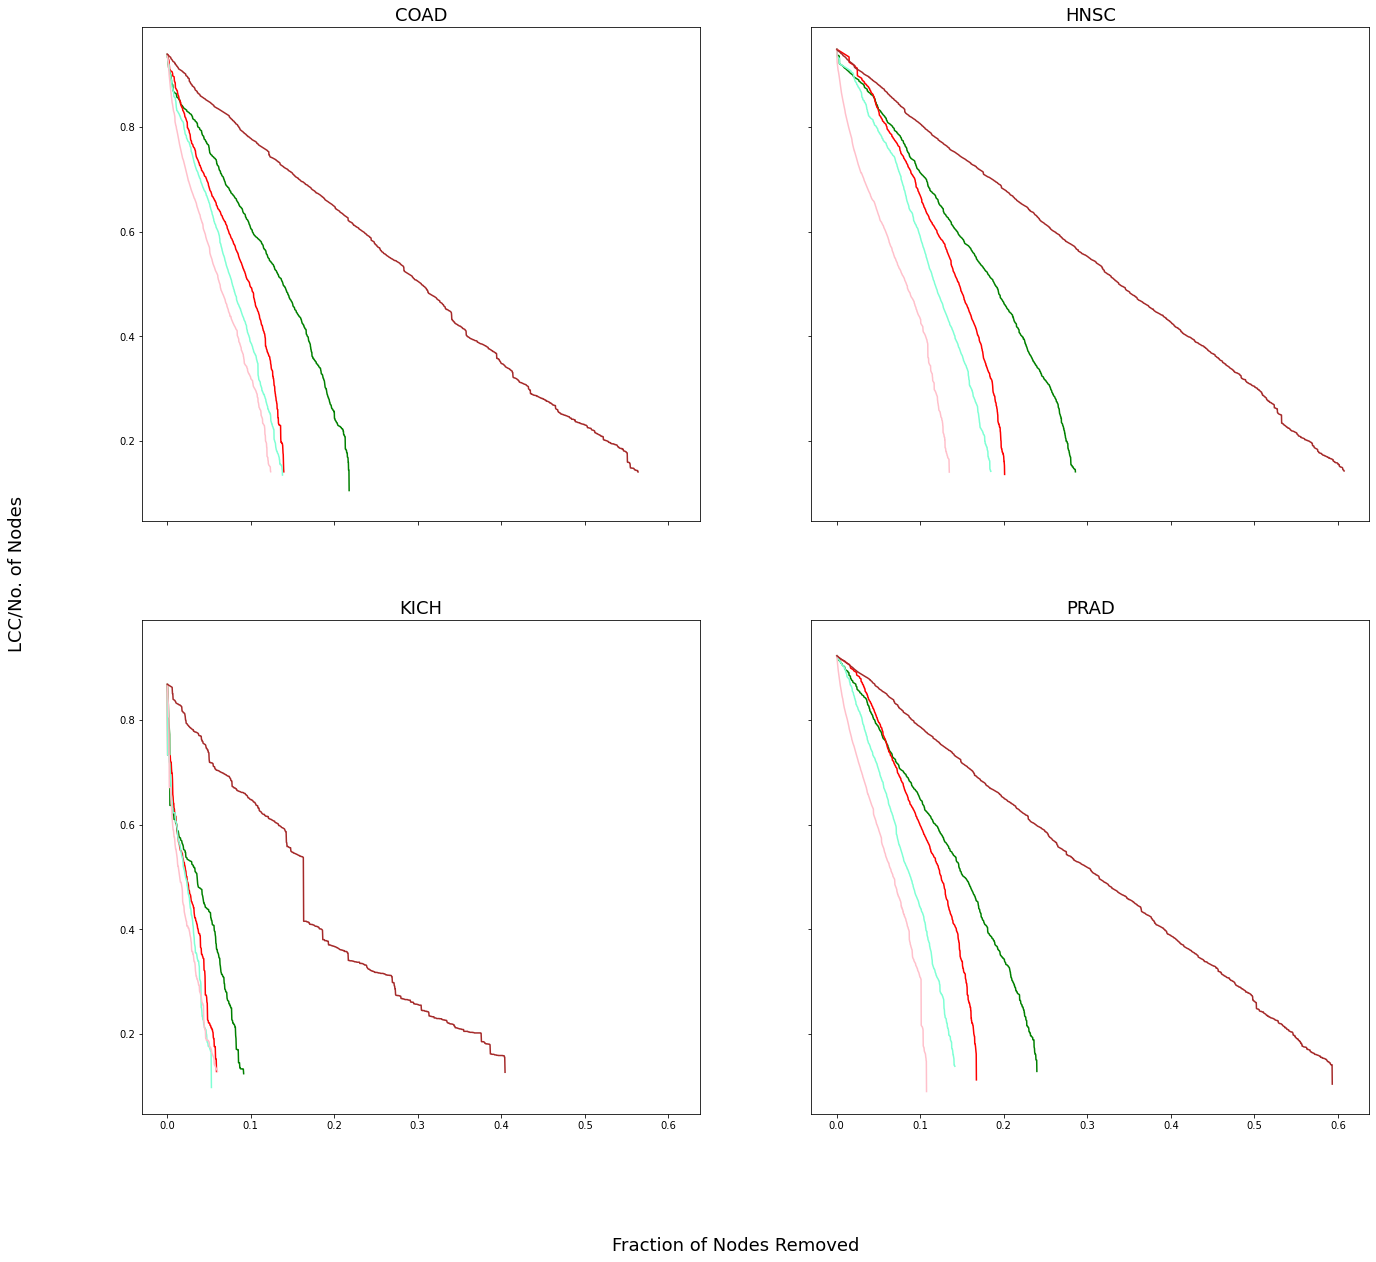

In [18]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD"]
x, y = 2, 2
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])